In [18]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from netgraph import Graph
import statistics

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [19]:
D_data = pd.read_csv('data/Denmark/Merged.csv')
USA_data = pd.read_csv('data/USA/filtered_USA_votes.csv')

In [24]:
#we check both ways, we calc both i -> j and j->i.
# person 221 as i and 1619 as j, and the other way. 1619 as i and 221 as j. is that a problem? 
#there are prob some variables that needs renaming

def calc_thres(PP, PA, PAV):
    party_agree = []
    for party in PP:
        #print(party)
        memb_agree = []
        for member1 in PP.get(party):
            for member2 in set(PP.get(party)):
                if member1 != member2:
                    common = set(PAV.get(member1)) & set(PAV.get(member2)) # how many votes do they agree on 
                
                    common2 = set(PA.get(member1)) & set(PA.get(member2)) # how many same bills have they voted on

                    if len(common) != 0: # if they have at least one vote thats the same, (too avoid divide by 0)
                    
                        percentage = len(common) / len(common2)
                        memb_agree.append(percentage)
                    else:
                        memb_agree.append(0)
        if len(memb_agree) != 0:
            avgMemb = sum(memb_agree)/len(memb_agree)
            std_dev = statistics.stdev(memb_agree) if len(memb_agree) > 1 else 0  # Avoid error for single-member case
            avg_plus_std = avgMemb + std_dev # Compute the sum of average and standard deviation
            party_agree.append(avg_plus_std)
            #print(avg_plus_std)
        #else:
            #print(party) # party where there is only one member
            #print('1')
            #party_agree.append(1)
    avgParty = sum(party_agree)/len(party_agree)
    #print(max(party_agree))
    return avgParty


In [21]:
def edgelist_calc(PA, PAV, threshold):
    edgelist=[]
    for i in PAV: # person 1

        for j in PAV: # for loop for person 2

            if i != j: # checks they are not the same

                common = set(PAV.get(i)) & set(PAV.get(j)) # how many votes do they agree on 
                
                common2 = set(PA.get(i)) & set(PA.get(j)) # how many same bills have they voted on

                if len(common) != 0: # if they have at least one vote thats the same, (too avoid divide by 0)
                    
                    percentage = len(common) / len(common2)
                    if percentage > threshold:
                        edgelist.append((i,j))
                

    return list(set(edgelist))
    

In [7]:
#----------------------------------------------------------------------------------------------------------------#
#----------------------------------------DENMARK-----------------------------------------------------------------#
#----------------------------------------------------------------------------------------------------------------#

In [22]:
#dict, key = id, values = (afstemningid, typeid)
# dict of all people with all their votes (voting id and what they voted)

PA = {}          #<<-------------- Person, Afstemning
for idx, row in D_data.iterrows():
    if row['aktørid'] not in PA:
        PA[row['aktørid']] = [(row['afstemningid'])]
    else:
        PA[row['aktørid']].append((row['afstemningid']))

PAV = {}          #<<-------------- Person, Afstemning, Vote
for idx, row in D_data.iterrows():
    if row['aktørid'] not in PAV:
        PAV[row['aktørid']] = [(row['afstemningid'],row['typeid_x'])]
    else:
        PAV[row['aktørid']].append((row['afstemningid'],row['typeid_x']))


PAVP = {}          #<<-------------- Person, Afstemning, Vote, Party
for idx, row in D_data.iterrows():
    if row['aktørid'] not in PAVP:
        PAVP[row['aktørid']] = [(row['afstemningid'],row['typeid_x'],row['party'],row['navn'])]
    else:
        PAVP[row['aktørid']].append((row['afstemningid'],row['typeid_x'],row['party'],row['navn']))
 
#dict of parties with memberid as values

PP = {}          #<<-------------- Party, Person
for idx, row in D_data.iterrows():
    if row['party'] not in PP:
        PP[row['party']] = [(row['aktørid'])]
    elif row['aktørid'] not in PP.get(row['party']):
        PP[row['party']].append((row['aktørid']))


In [23]:
D_thres = calc_thres(PP,PA,PAV)
D_thres

1.1611754382183737
1.192238438789837
1.1997863397931907
1.167039048312144
1.0443838336450277
1.0744286466237274
1.0613411165779993
1.0585224841492313
0.972348696127775
1.1852336600286273
0.9365724606665985
0.7679884263148602
0.0
0.0
0.9975961538461539
1.1997863397931907


0.9212436495395695

In [25]:
edgelist = edgelist_calc(PA,PAV, D_thres)
G_denmark = nx.from_edgelist(edgelist)

In [26]:
len(edgelist)

24460

In [27]:
list_of_dangle = [node for node in G_denmark.nodes if G_denmark.degree(node) == 0]
list_of_dangle

[]

In [13]:
#----------------------------------------------------------------------------------------------------------------#
#------------------------------------------USA-------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------------------------#


In [28]:
U_PA = {}          #<<-------------- Person, Afstemning
for idx, row in USA_data.iterrows():
    if row['congress'] == 118:
        if row['icpsr'] not in U_PA:
            U_PA[row['icpsr']] = [(row['rollnumber'])]
        else:
            U_PA[row['icpsr']].append((row['rollnumber']))

U_PAV = {}          #<<-------------- Person, Afstemning, Vote
for idx, row in USA_data.iterrows():
    if row['congress'] == 118:
        if row['icpsr'] not in U_PAV:
            U_PAV[row['icpsr']] = [(row['rollnumber'],row['cast_code'])]
        else:
            U_PAV[row['icpsr']].append((row['rollnumber'],row['cast_code']))


U_PAVP = {}          #<<-------------- Person, Afstemning, Vote, Party
for idx, row in USA_data.iterrows():
    if row['congress'] == 118:
        if row['icpsr'] not in U_PAVP:
            U_PAVP[row['icpsr']] = [(row['rollnumber'],row['cast_code'],row['party_code'])]
        else:
            U_PAVP[row['icpsr']].append((row['rollnumber'],row['cast_code'],row['party_code']))

#dict of parties with memberid as values

U_PP = {}          #<<-------------- Party, Person
for idx, row in USA_data.iterrows():
    if row['congress'] == 118:
        if row['party_code'] not in U_PP:
            U_PP[row['party_code']] = [(row['icpsr'])]
        elif row['icpsr'] not in U_PP.get(row['party_code']):
            U_PP[row['party_code']].append((row['icpsr']))

In [29]:
U_thres = calc_thres(U_PP, U_PA, U_PAV)

In [32]:
U_edgelist = edgelist_calc(U_PA, U_PAV, U_thres)
G_USA = nx.from_edgelist(U_edgelist)

In [33]:
list_of_dangle = [node for node in G_USA.nodes if G_USA.degree(node) == 0]
list_of_dangle

[]

76572

In [34]:
# Create node to community mapping based on party codes
node_to_community = {}
party_to_community = {
    100: 0,  # Democrat
    200: 1,  # Republican 
    328: 2,  # Independent
}

for icpsr in U_PAVP:
    party_code = U_PAVP[icpsr][0][2]  # Get party code from first vote
    node_to_community[icpsr] = party_to_community.get(party_code, 3)  # Default 3 for other parties

# Color mapping
community_to_color = {
    0: 'blue',      # Democrats
    1: 'red',       # Republicans
    2: 'green',     # Independents
    3: 'gray'       # Others
}
node_color = {node: community_to_color[community_id] 
              for node, community_id in node_to_community.items()}



c:\Users\kubic\OneDrive\Dokumenty\lib\site-packages\netgraph\_node_layout.py:1550: UserWarning: Graph contains a single community. Unable to compute a community layout. Computing spring layout instead.
  warnings.warn("Graph contains a single community. Unable to compute a community layout. Computing spring layout instead.")


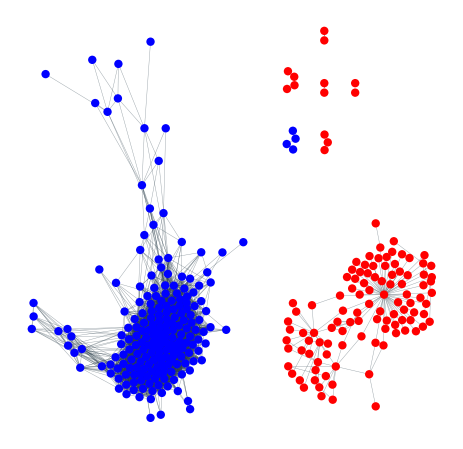

In [35]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
Graph(G_USA,
      node_color=node_color,
      node_edge_width=0,
      node_size=1,
      edge_width=0.1,
      edge_alpha=0.5,
      node_layout='community', 
      node_layout_kwargs=dict(node_to_community=node_to_community),
      ax=ax)
plt.show()

In [30]:
set(D_data['party'])

{'Alternativet',
 'Borgernes Parti',
 'Danmarksdemokraterne',
 'Dansk Folkeparti',
 'Det Konservative Folkeparti',
 'Enhedslisten',
 'Frie Grønne',
 'Inuit Ataqatigiit',
 'Javnaðarflokkurin',
 'Liberal Alliance',
 'Moderaterne',
 'Radikale Venstre',
 'Sambandsflokkurin',
 'Siumut',
 'Socialdemokratiet',
 'Socialistisk Folkeparti',
 'Uden for folketingsgrupperne',
 'Venstre'}

In [30]:
# Create node to community mapping based on party codes
node_to_community = {}
party_to_community = {
    'Alternativet': 0,  
    'Danmarksdemokraterne': 1,   
    'Dansk Folkeparti': 2,
    'Det Konservative Folkeparti': 3,
    'Enhedslisten': 4,
    'Frie Grønne': 5,
    'Liberal Alliance': 6,
    'Moderaterne': 7,
    'Radikale Venstre': 8,
    'Sambandsflokkurin': 9,
    'Siumut': 10,
    'Socialdemokratiet': 11,
    'Socialistisk Folkeparti': 12,
    'Uden for folketingsgrupperne': 13,
    'Venstre': 14,
     

}

# Color mapping
community_to_color = {
   0: 'blue',
   1: 'red', 
   2: 'green',
   3: 'purple',
   4: 'orange',
   5: 'cyan',
   6: 'magenta',
   7: 'yellow',
   8: 'brown',
   9: 'pink',
   10: 'gray',
   11: 'olive',
   12: 'teal',
   13: 'navy',
   14: 'lightblue'
}

node_to_community = {}
for aktor_id in PAVP:
   party_name = PAVP[aktor_id][0][2]  # Get party name from first vote
   node_to_community[aktor_id] = party_to_community.get(party_name, 0)

node_color = {node: community_to_color[community_id] 
              for node, community_id in node_to_community.items()}

c:\Users\kubic\OneDrive\Dokumenty\lib\site-packages\netgraph\_node_layout.py:1621: UserWarning: There are no connections within community 10. The placement of of nodes within this community is arbitrary.
  warnings.warn(f"There are no connections within community {community}. The placement of of nodes within this community is arbitrary.")
c:\Users\kubic\OneDrive\Dokumenty\lib\site-packages\netgraph\_node_layout.py:1621: UserWarning: There are no connections within community 9. The placement of of nodes within this community is arbitrary.
  warnings.warn(f"There are no connections within community {community}. The placement of of nodes within this community is arbitrary.")
c:\Users\kubic\OneDrive\Dokumenty\lib\site-packages\netgraph\_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


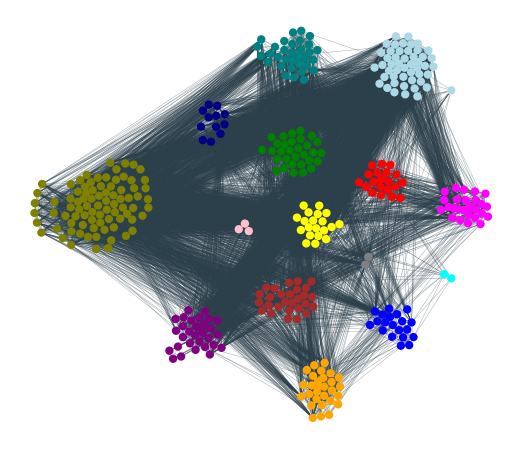

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
Graph(G_denmark,
      node_color=node_color,
      node_edge_width=0,
      node_size=1,
      edge_width=0.1,
      edge_alpha=0.5,
      node_layout='community', 
      node_layout_kwargs=dict(node_to_community=node_to_community),
      ax=ax)
plt.show()